# Instruction


*   Feel free to modify the skeleton code as needed. It is provided solely as a framework for your solution.
*   You must submit this notebook in both .html and .ipynb formats.
*   Ensure to change your runtime to GPU for faster training.




#Objectives

In this assignment, you will use vision transformer for image classification on MNIST dataset:

Most of the code for this homework has been provided to you in this notebook and you should be able to train the model as it is to see how it works.

You need to do these tasks:


1.   **Patch Extraction**: Run *img_to_patch* on a batch of images from train_dataloader with both *flatten_channels=True* and *flatten_channels=False* and *patch_size=4*, then discuss about shape of the output: What does each dimension show?
2.   **Training**: Train the model for 10 epochs and show learning curves.
3.   **Visualization of cosine similarity of positional embeddings**: you need to extract positional embeddings from the model before and after training, calculate the cosine similarity between all pairs of positional embeddings, and visualize the results. You can use *torch.nn.functional.cosine_similarity* for this task.

4.	**Visualization of attention maps**: your task is to modify the TransformerBlock class/ and ViT model such that it returns the attention weights from the self_attention layer during the forward pass. You will then visualize the attention maps for the last layer which are averaged over the heads. (You need to train the model again after making these changes.)




#Importing Required Libraries

Let's start by importing the necessary libraries.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


# For repeatable experiments
random_seed = 32
torch.manual_seed(random_seed)

# Loading the Dataset and creating dataloaders

### Download Dataset

In this assignment, you'll be working on MNIST Dataset which contains over 60,000 images of handwritten digits.
The first step is to download the dataset:



In [2]:
# Downloading training data for MNIST dataset
train_dataset = MNIST(root="dataset/",
                      train=True,
                      download=True,
                      transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                      ]))

# Downloading testing data for MNIST dataset
test_dataset = MNIST(root="dataset/",
                     train=False,
                     download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307,), (0.3081,))
                     ]))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.3MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.05MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.61MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Create DataLoader

Now, let's define our dataloader to pass samples in **minibatches**.

In [3]:
train_batch_size = 64
test_batch_size=128

# Create data loaders to iterate over data
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(f"Training data size: {len(train_loader.dataset)}")
print(f"Test data size: {len(test_loader.dataset)}")



# Displaying the shape of a single batch from the train loader
train_examples = enumerate(train_loader)
batch_idx, (train_images, train_labels) = next(train_examples)

print(f"Shape of images in train loader [B, C, H, W]: {train_images.shape}")
print(f"Shape of labels in train loader [B]: {train_labels.shape}")



Training data size: 60000
Test data size: 10000
Shape of images in train loader [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of labels in train loader [B]: torch.Size([64])


Let's check size of each batch in our train_loader:

In [4]:
# Displaying the shape of a single batch from the train loader
train_examples = enumerate(train_loader)
batch_idx, (train_images, train_labels) = next(train_examples)

print(f"Shape of images in train loader [B, C, H, W]: {train_images.shape}")
print(f"Shape of labels in train loader [B]: {train_labels.shape}")

Shape of images in train loader [B, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of labels in train loader [B]: torch.Size([64])


### Visualizing Sample Images

Let's visualize some of sample images from the train_dataset:

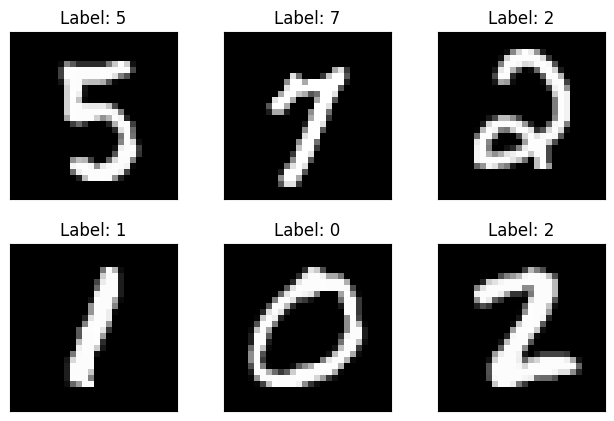

In [5]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(train_images[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


# Vision Transformer




### Patch Extraction

Patch extraction is the first step in Vision Transformer (ViT) architecture, it divides the input image into smaller, non-overlapping patches that can be processed independently.
Here, we defined a function that divides images into patches:  

In [6]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

Run this function with **flatten_channels=True** and **flatten_channels=False** on the same batch from the previous cells, set **batch_size=4** and discuss the shape of the output: what each dimension corresponds to?

In [7]:
sample_image = train_images[0].unsqueeze(0)
print(f"Shape of first image: {sample_image.shape}")

patch_size = 4


Shape of first image: torch.Size([1, 1, 28, 28])


In [8]:
patches = img_to_patch(train_images[0].unsqueeze(0) , patch_size = 4  , flatten_channels=False)


In [9]:
patches

tensor([[[[[-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242]]],


         [[[-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242]]],


         [[[-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242]]],


         [[[-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242]]],


         [[[-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242, -0.4242]]],




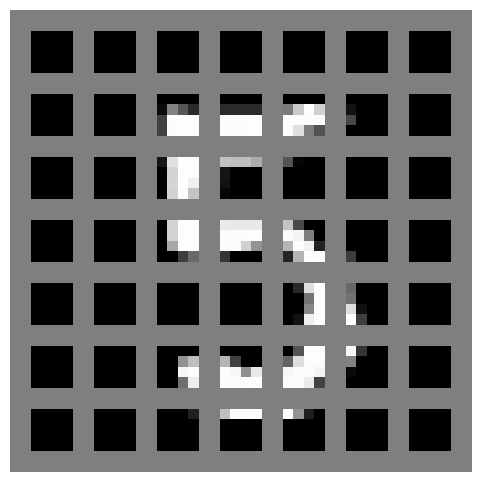

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
img_grid = make_grid(patches[0], nrow=int(sample_image.shape[2] / patch_size), normalize=True, pad_value=0.5)
ax.imshow(img_grid.permute(1, 2, 0), cmap='gray')
ax.axis('off')
plt.show()


In [11]:
patches_flatten = img_to_patch(train_images[0].unsqueeze(0) , patch_size = 4  , flatten_channels=True)
patches_flatten

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.424

Notice how setting flatten_channels affects the shape of the output.

Now, let's visualize the patches to see how they look. In this case, we will use the output of the **img_to_patch** function with **flatten_channels=False**.
We will use **torchvision.utils.make_grid** to visualize the patches as a grid. The **plot_patches** function allows you to control the display by setting **seq=False** to view the patches in their original image shape or **seq=True** to display the image as a sequence of patches.


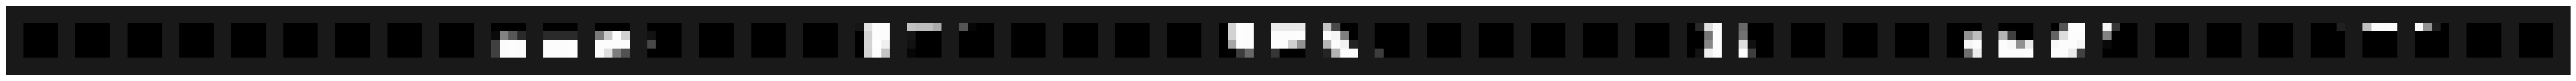

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(55, 55))
img_grid = make_grid(patches[0], nrow=49, normalize=True, pad_value=0.1)
ax.imshow(img_grid.permute(1, 2, 0), cmap='gray')
ax.axis('off')
plt.show()

By looking at each individual patch, you can see that recognizing the digits is much harder compared to seeing the whole image. Yet, this is the input we give to the Transformer for digit classification. The model must figure out how to piece these patches together on its own to accurately identify the digits.

### Tranformer Block


In Vision Transformers, after the image is divided into patches during patch extraction, each patch is flattened and converted into a token through embedding. These token embeddings are then processed by the transformer block, which is key to learning the relationships between different regions of the image.

The Transformer block consists of two main components:


*   **Multi-head self-attention**: which allows the model to focus on different patches simultaneously and,
*   **Feedforward neural network (MLP)**: for further transformation.

Layer normalization is applied before each mechanism to ensure stability and enhance learning efficiency.


In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim=128, num_heads=4):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True, dropout=0.1)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim),
        )

    def forward(self, x, return_attention=False):
        # Apply Layer Normalization
        norm_x = self.layer_norm1(x)

        # Perform multi-head self-attention
        attn_output, attn_weights = self.self_attention(norm_x, norm_x, norm_x)  # attn_weights shape: [batch, num_heads, num_tokens, num_tokens]

        # Residual connection
        x = x + attn_output

        # Second Layer Normalization and feed-forward network
        norm_x = self.layer_norm2(x)
        feed_forward_output = self.feed_forward(norm_x)
        x = x + feed_forward_output

        if return_attention:
            # Return both output and attention weights
            return x, attn_weights
        return x


### ViT Model

The vision transformer architecture for an image classification task follows these steps:


*   **Patch Extraction**: Split the image into fixed-size patches and flatten them.
*   **Patch Embedding**: Apply linear embeddings to the flattened patches (project them to the hidden size dimension).
*   **Add positional embeddings**: Add positional embeddings to patch embeddings.
*   **Concatenate output token**: Append the output token to the sequence of patch embeddings.
*   **Transformer block processing**: Pass the sequence of embeddings through a transformer encoder.
*   **Classification**: Use the output token embedding for the final classification.



In [14]:
class ViT(nn.Module):
    def __init__(self, img_size, in_channels, num_classes, patch_size, hidden_size, num_layers, num_heads=8):
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.patch_embed = nn.Linear(in_channels * patch_size * patch_size, hidden_size)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_size) * 0.001)

    def forward(self, x, return_attention=False):
        batch_size = x.size(0)
        patch_seq = img_to_patch(x, self.patch_size, flatten_channels=True)
        patch_embeddings = self.patch_embed(patch_seq)
        patch_embeddings += self.pos_embed
        cls_token = self.cls_token.expand(batch_size, 1, -1)
        embeddings = torch.cat((cls_token, patch_embeddings), dim=1)

        attention_maps = []
        for i, block in enumerate(self.transformer_blocks):
            if return_attention:
                embeddings, attn_weights = block(embeddings, return_attention=True)
                attention_maps.append(attn_weights)
            else:
                embeddings = block(embeddings)

        # Average attention across all layers
        if return_attention:
            all_attention = torch.stack(attention_maps).mean(0)
            return self.classifier(embeddings[:, 0]), all_attention
        return self.classifier(embeddings[:, 0])
"""
    def forward(self, x, return_attention=False):
        batch_size = x.size(0)
        patch_seq = img_to_patch(x, self.patch_size, flatten_channels=True)
        patch_embeddings = self.patch_embed(patch_seq)
        patch_embeddings += self.pos_embed
        cls_token = self.cls_token.expand(batch_size, 1, -1)
        embeddings = torch.cat((cls_token, patch_embeddings), dim=1)

        attention_map = None
        for i, block in enumerate(self.transformer_blocks):
            if return_attention and i == len(self.transformer_blocks) - 1:
                embeddings, attention_map = block(embeddings, return_attention=True)
            else:
                embeddings = block(embeddings)

        return self.classifier(embeddings[:, 0]), attention_map
"""

'\n    def forward(self, x, return_attention=False):\n        batch_size = x.size(0)\n        patch_seq = img_to_patch(x, self.patch_size, flatten_channels=True)\n        patch_embeddings = self.patch_embed(patch_seq)\n        patch_embeddings += self.pos_embed\n        cls_token = self.cls_token.expand(batch_size, 1, -1)\n        embeddings = torch.cat((cls_token, patch_embeddings), dim=1)\n\n        attention_map = None\n        for i, block in enumerate(self.transformer_blocks):\n            if return_attention and i == len(self.transformer_blocks) - 1:\n                embeddings, attention_map = block(embeddings, return_attention=True)\n            else:\n                embeddings = block(embeddings)\n\n        return self.classifier(embeddings[:, 0]), attention_map\n'

# Training

### Device Configuration for Training

Ensure that you have set your device to GPU:

In [15]:
# Get device for training.
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


Let's check the model's structure:




In [16]:
patch_size=4
num_classes = 10

# Let's define our model:
model = ViT(img_size=train_images.shape[2],
            in_channels=train_images.shape[1],
            num_classes = num_classes,
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

# View the model's architecture
print(model)

ViT(
  (patch_embed): Linear(in_features=16, out_features=128, bias=True)
  (transformer_blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


Before we start training, let's check the shape of model's output when fed a single batch:

In [17]:
train_examples = enumerate(train_loader)
batch_idx, (train_images, train_labels) = next(train_examples)

# Pass image through network
out= model(train_images.to(device))
# Check input and output's shapes
print(f"Shape of images in train loader [B, C, H, W]: {train_images.shape}")
#print(f"Shape of images in train loader [B, num_classes]: {out.shape}")

Shape of images in train loader [B, C, H, W]: torch.Size([64, 1, 28, 28])


### Train Function

Here, we define our training function that is used to train the model.



In [18]:
def train(dataloader, model, loss_fn, optimizer, epoch, train_losses, train_acc):
    model.train()
    training_loss = 0
    correct = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        output = model(images)  # Unpack to get only the classification output
        loss = loss_fn(output, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        training_loss += loss.item()
        correct += (output.argmax(1) == labels).type(torch.float).sum().item()

    # Average loss and accuracy for the epoch
    training_loss /= len(dataloader)
    train_accuracy = 100 * correct / len(dataloader.dataset)
    train_losses.append(training_loss)
    train_acc.append(train_accuracy)

    print(f"Epoch {epoch+1} \n Train Accuracy: {train_accuracy:.1f}%, Train loss: {training_loss:.6f}")


def test(dataloader, model, loss_fn, epoch, val_losses, val_acc):
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output= model(images)  # Unpack to get only the classification output
            loss = loss_fn(output, labels)

            # Calculate metrics
            val_loss += loss.item()
            correct += (output.argmax(1) == labels).type(torch.float).sum().item()

    # Average loss and accuracy for the epoch
    val_loss /= len(dataloader)
    val_accuracy = 100 * correct / len(dataloader.dataset)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1} \n Test Accuracy: {val_accuracy:.1f}%, Test loss: {val_loss:.6f}")


### Test Function

The test function evaluates the model's predictive performance using the **test_dataloader**.




### Training Loop

Now, we need to define our loss function and optimizer and start training.


In [19]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


def visualize_positional_embeddings(model):
    pos_embeddings = model.pos_embed.detach().cpu().squeeze(0)

    cos_sim_matrix = F.cosine_similarity(pos_embeddings[:, None, :], pos_embeddings[None, :, :], dim=-1)

    num_patches = pos_embeddings.size(0)
    grid_size = int(math.sqrt(num_patches))

    cos_sim_grids = cos_sim_matrix.view(grid_size, grid_size, grid_size, grid_size).permute(0, 2, 1, 3).reshape(grid_size * grid_size, grid_size, grid_size)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("Cosine Similarity Heatmap for Each Patch", fontsize=16)

    for i in range(grid_size * grid_size):
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(cos_sim_grids[i], cmap="viridis", vmin=-1, vmax=1)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.colorbar(axes[0, 0].imshow(cos_sim_grids[0], cmap="viridis", vmin=-1, vmax=1), ax=axes, location='right', label="Cosine Similarity")
    plt.show()


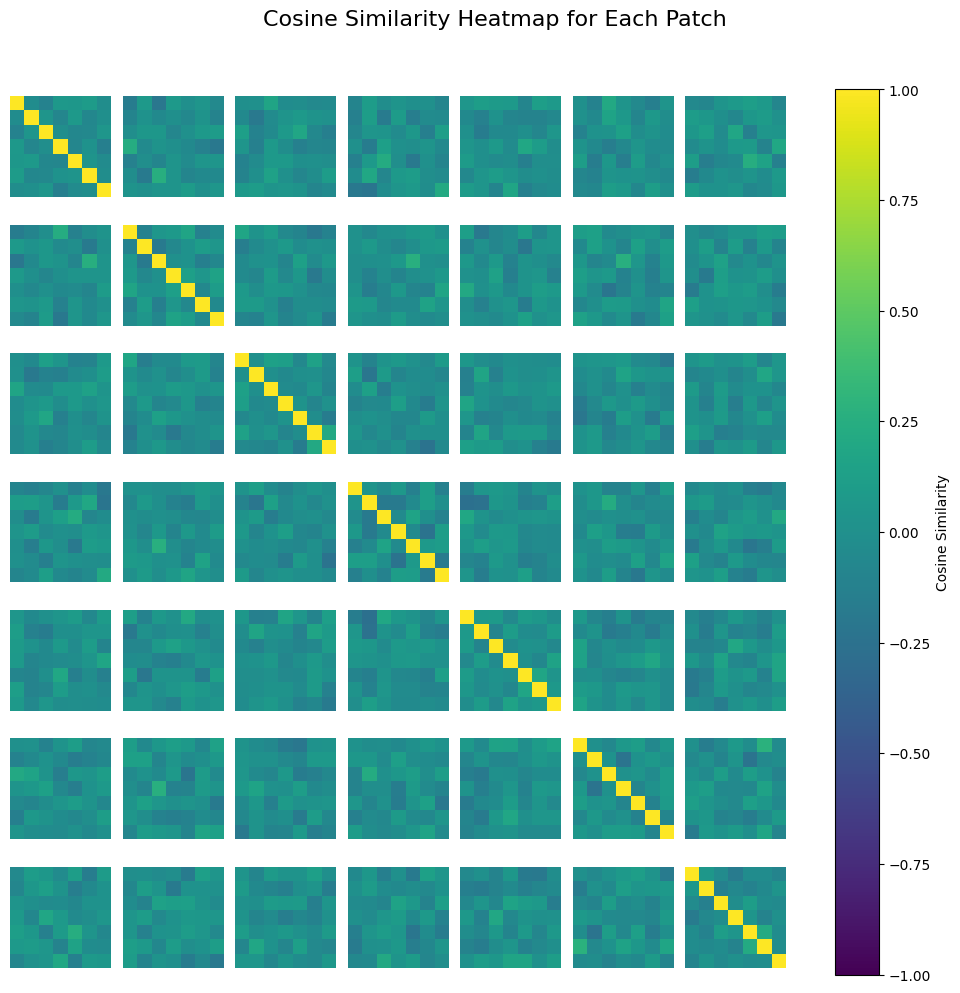

In [20]:
# Define our learning rate, loss function and optimizer
epochs = 10
learning_rate = 0.001
patch_size = 4
n_classes = 10

model = ViT(img_size=train_images.shape[2],
            in_channels=train_images.shape[1],
            num_classes = num_classes,
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=epochs,
                                                    eta_min=0)
train_losses, train_acc = [], []
val_losses, val_acc = [], []

visualize_positional_embeddings(model)


In [21]:
# Example of handling attention during visualization or specific testing



100%|██████████| 938/938 [01:05<00:00, 14.33it/s]


Epoch 1 
 Train Accuracy: 77.5%, Train loss: 0.658327


100%|██████████| 79/79 [00:03<00:00, 22.78it/s]


Epoch 1 
 Test Accuracy: 95.3%, Test loss: 0.146159


100%|██████████| 938/938 [00:42<00:00, 22.25it/s]


Epoch 2 
 Train Accuracy: 94.6%, Train loss: 0.171168


100%|██████████| 79/79 [00:04<00:00, 17.78it/s]


Epoch 2 
 Test Accuracy: 95.8%, Test loss: 0.137840


100%|██████████| 938/938 [00:51<00:00, 18.30it/s]


Epoch 3 
 Train Accuracy: 96.0%, Train loss: 0.125147


100%|██████████| 79/79 [00:04<00:00, 17.66it/s]


Epoch 3 
 Test Accuracy: 95.4%, Test loss: 0.149139


100%|██████████| 938/938 [00:45<00:00, 20.67it/s]


Epoch 4 
 Train Accuracy: 97.0%, Train loss: 0.095103


100%|██████████| 79/79 [00:03<00:00, 24.33it/s]


Epoch 4 
 Test Accuracy: 97.0%, Test loss: 0.098750


100%|██████████| 938/938 [00:39<00:00, 23.82it/s]


Epoch 5 
 Train Accuracy: 97.7%, Train loss: 0.073712


100%|██████████| 79/79 [00:04<00:00, 18.54it/s]


Epoch 5 
 Test Accuracy: 98.1%, Test loss: 0.063028


100%|██████████| 938/938 [00:42<00:00, 21.86it/s]


Epoch 6 
 Train Accuracy: 98.3%, Train loss: 0.053378


100%|██████████| 79/79 [00:04<00:00, 18.17it/s]


Epoch 6 
 Test Accuracy: 98.2%, Test loss: 0.058299


100%|██████████| 938/938 [00:52<00:00, 17.87it/s]


Epoch 7 
 Train Accuracy: 99.0%, Train loss: 0.031992


100%|██████████| 79/79 [00:05<00:00, 15.23it/s]


Epoch 7 
 Test Accuracy: 98.3%, Test loss: 0.054757


100%|██████████| 938/938 [00:45<00:00, 20.64it/s]


Epoch 8 
 Train Accuracy: 99.5%, Train loss: 0.016183


100%|██████████| 79/79 [00:04<00:00, 18.51it/s]


Epoch 8 
 Test Accuracy: 98.8%, Test loss: 0.044050


100%|██████████| 938/938 [00:45<00:00, 20.70it/s]


Epoch 9 
 Train Accuracy: 99.8%, Train loss: 0.007326


100%|██████████| 79/79 [00:05<00:00, 15.12it/s]


Epoch 9 
 Test Accuracy: 98.7%, Test loss: 0.044878


100%|██████████| 938/938 [00:51<00:00, 18.15it/s]


Epoch 10 
 Train Accuracy: 99.9%, Train loss: 0.003491


100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


Epoch 10 
 Test Accuracy: 98.8%, Test loss: 0.041983
Finished!


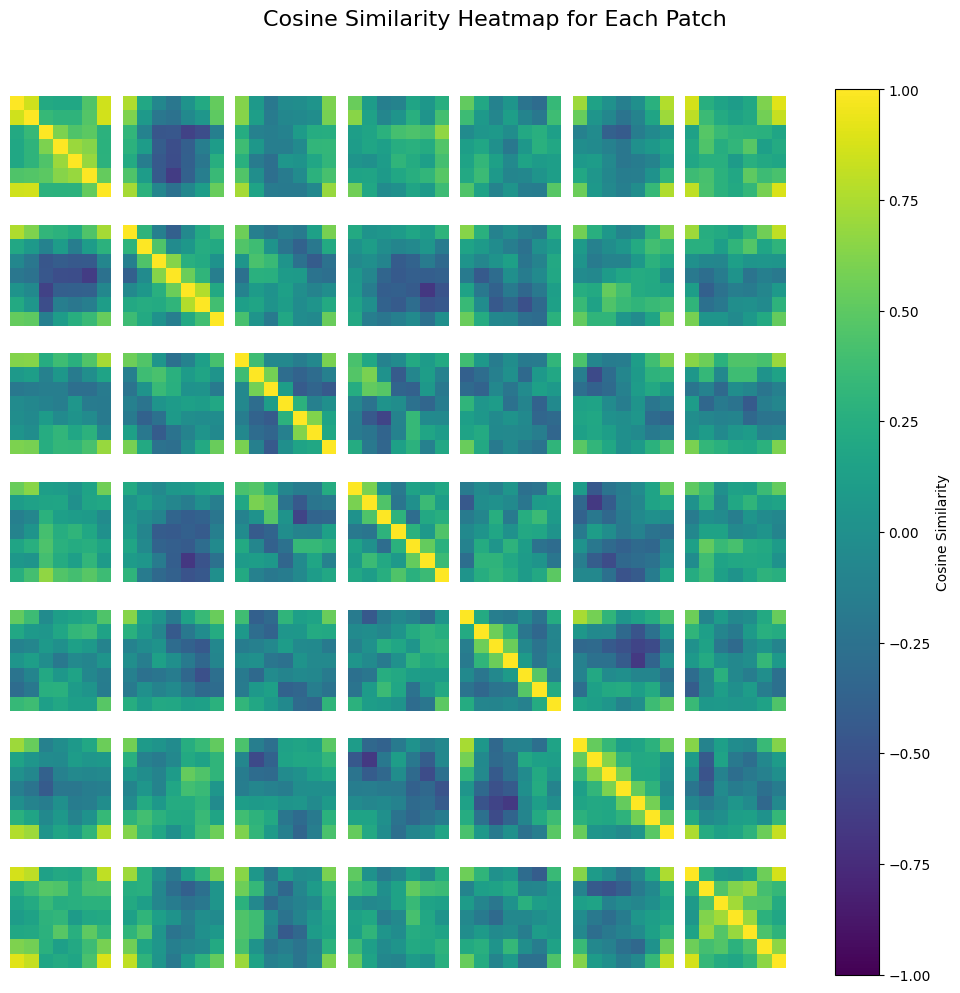

In [22]:
for epoch in range(epochs):
    train(train_loader, model, loss_fn, optimizer, epoch, train_losses, train_acc)
    test(test_loader, model, loss_fn, epoch, val_losses, val_acc)
    lr_scheduler.step()
print("Finished!")



visualize_positional_embeddings(model)


#Inference and plotting the learning curves

Let's see how model performs on the first 10 samples in the test dataloader:

In [26]:
import os
import torch

# Save model parameters
if not os.path.exists('model'):
    os.makedirs('model')

torch.save(model.state_dict(), "model/VIT_Model.pth")
print("Saved PyTorch Model State to model/VIT_Model.pth")

# Load the saved model parameters into a new instance of the model
model = ViT(img_size=train_images.shape[2],
            in_channels=train_images.shape[1],
            num_classes=num_classes,
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

# Load model with security consideration
model.load_state_dict(torch.load("model/VIT_Model.pth", map_location=device, weights_only=True))

model.eval()
for i in range(10):
    x, y = test_dataset[i][0], test_dataset[i][1]
    x = x.to(device)

    pred = model(x.unsqueeze(0))
    predicted = pred[0].argmax().item()  # Corrected to use argmax(1)

    print(f'Predicted: "{predicted}", Actual: "{y}"')


Saved PyTorch Model State to model/VIT_Model.pth
Predicted: "7", Actual: "7"
Predicted: "2", Actual: "2"
Predicted: "1", Actual: "1"
Predicted: "0", Actual: "0"
Predicted: "4", Actual: "4"
Predicted: "1", Actual: "1"
Predicted: "4", Actual: "4"
Predicted: "9", Actual: "9"
Predicted: "5", Actual: "5"
Predicted: "9", Actual: "9"


Let's plot the learning curves:

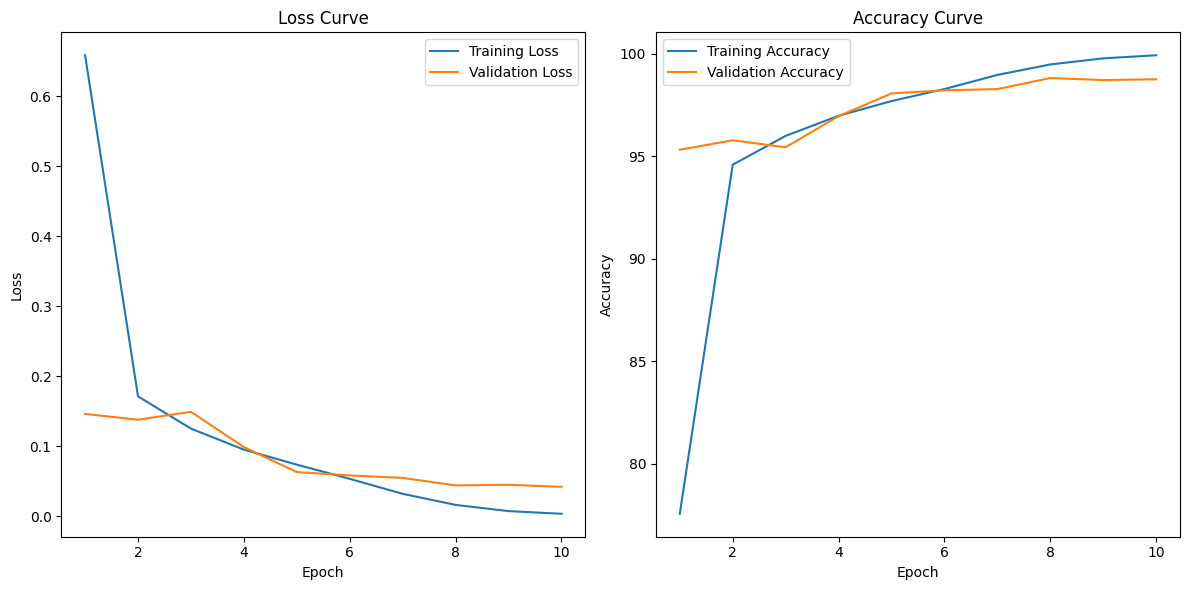

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the learning curve for loss
ax1.plot(range(1, epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()

# Plot the learning curve for accuracy
ax2.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
ax2.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curve')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Positional Embeddings

Positional embeddings in ViT are typically initialized randomly, with no clear pattern or relationship at first. As the model trains, these embeddings evolve to encode meaningful positional information.

In this part of the assignment, you'll visualize how this evolves by examining the cosine similarity between positional embeddings before and after training. Here's what you need to do:



*   Extract positional embeddings from the ViT model before and after training.
*   Compute the cosine similarity between each pair of embeddings to observe how similar each patch's position is to others.
*   Reshape and visualize these similarities in a grid, creating a similarity heatmap for each patch.
*   Use **torch.nn.functional.cosine_similarity** for the calculations.







In [ ]:
'''

# Your code here

'''


# Attention Map

Attention in Transformers allows the model to focus on different parts of the input, assigning weights that reflect the importance of each patch relative to others. In Vision Transformers (ViTs), attention helps capture spatial relationships by highlighting key areas of an image that are crucial for prediction. As the model processes deeper layers, these attention maps become more refined, showing which patches the model relies on to make decisions. Visualizing these attention maps provides insight into how the model interprets and focuses on different regions of the image during inference.

In this part of the assignment, you'll then visualize how attention evolves across patches. For this task, you need to:

*    Modify the TransformerBlock and ViT model to return attention weights during the forward pass. (Adjust the train and test functions accordingly.)
*    Average attentions across head
*    Exclude the class token from the attention map for visualization.
*   Use **torch.nn.functional.interpolate** to resize the attention map to match the image size for better interpretability.
*   Use matplotlib or any other library of your choice to visualize the attention maps.
*   Visualize attention map for test_dataset[50] and test_dataset[160]


In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

def visualize_attention_map(model, dataset, index, img_size):
    model.eval()  # Set model to evaluation mode
    image, label = dataset[index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        _, attention_map = model(image, return_attention=True)

    if attention_map is not None:
        # Remove class token and average across heads
        attention_map = attention_map[:, 1:, 1:].mean(dim=0)

        # Calculate the correct number of patches per side
        num_patches_per_side = 49
        attention_map = attention_map.view(1, 1, num_patches_per_side, num_patches_per_side)

        # Interpolate the attention map to the size of the original image
        attention_map = F.interpolate(attention_map, size=(img_size, img_size), mode='bilinear', align_corners=False)
        attention_map = attention_map.squeeze(0).squeeze(0).cpu().numpy()  # Convert to numpy for visualization

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Original Image (Label: {label})")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(attention_map, cmap='hot')
        plt.title('Attention Map')
        plt.axis('off')

        plt.show()
    else:
        print("No attention map returned by the model.")

# Example usage


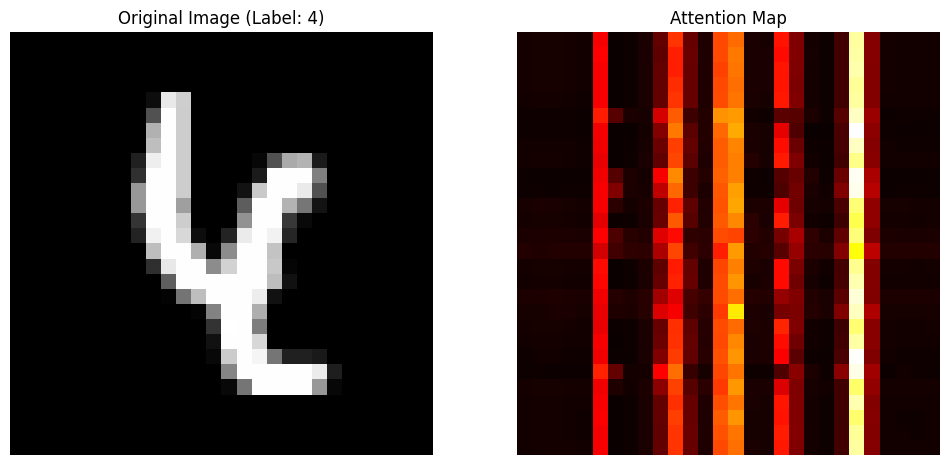

In [43]:


visualize_attention_map(model, test_dataset, 160, img_size=train_images.shape[2])


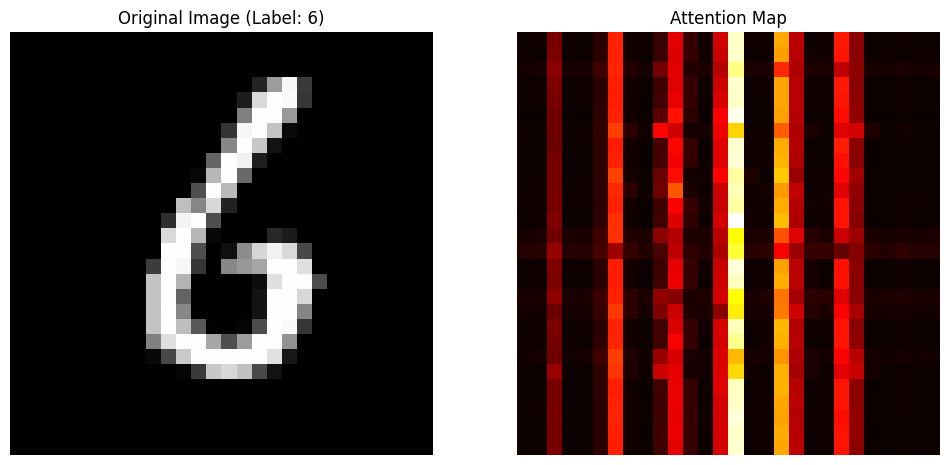

In [37]:
visualize_attention_map(model, test_dataset, 50, img_size=train_images.shape[2])

# Acknowledgment

This Assignment is based on:

*   A Course provided by [IBM](https://cognitiveclass.ai/courses/vision-transformers-for-image-classification-hands-on)
